In [1]:
import Pkg; Pkg.add("JuMP");  Pkg.add("GLPK");  Pkg.add("Random"); 

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


In [2]:
using JuMP
using GLPK
using Random
using Plots

In [3]:
# Dados do problema
n = 22  # número de operações
m = 10  # número de trabalhadores
production_times = [
    0.287857 0.830655 0.100000 0.248239 0.727981 0.655542 0.123721 1.341410 0.607163 0.650595 0.952860 0.516485 1.108985 0.390380 0.468933 1.001196 0.867240 0.500933 0.103134 0.034181 0.100000 0.865475 
    0.214674 0.677245 0.218670 0.334460 0.377926 0.098116 0.116527 0.373527 0.766943 0.487008 0.616509 0.981799 0.689655 1.183141 0.577251 0.656511 0.579161 0.253087 0.702422 0.577560 0.149161 1.524006 
    0.563387 0.373777 1.177244 0.407656 0.714569 0.766731 0.596989 1.386659 0.100000 0.364007 0.576406 0.248855 0.921155 0.100000 0.540836 0.496036 0.292919 0.890136 0.428335 0.616562 0.980137 1.443171 
    0.701306 0.372571 0.286429 0.776129 0.151218 0.430800 0.441205 0.592415 0.682784 0.963321 0.497589 0.215186 1.343249 0.560373 0.118498 0.416314 0.682767 1.117920 1.010403 0.441521 0.408943 1.073101 
    0.728880 0.339696 0.300568 0.461422 0.403869 0.577566 0.100000 0.290065 0.181337 0.100000 0.108598 0.100000 1.355450 0.952505 0.335884 0.100000 0.100000 0.057663 0.035723 0.106526 0.024241 1.451221 
    1.032563 0.461030 0.097871 0.139404 0.217762 0.172444 0.710332 0.921559 0.588515 0.860334 0.940454 0.519992 0.534624 0.973526 0.355370 0.321430 0.245714 0.752854 1.399322 0.225037 0.107761 0.707324 
    0.237756 0.346072 0.060057 0.195576 0.597975 0.487688 0.100000 0.235052 0.513761 0.321723 0.809187 0.463609 0.585087 0.310646 0.864026 0.737609 0.688433 0.669295 0.414836 0.509546 0.261491 1.424095 
    0.357533 0.330183 0.180000 0.126193 0.039703 0.100000 0.133739 0.460826 0.559455 0.478390 0.527090 0.100000 0.675302 0.638178 0.100000 0.254398 0.347360 0.415945 0.949802 0.100000 0.060807 0.913300 
    0.444417 0.100000 0.272252 0.522473 0.289680 0.365973 0.688991 0.691261 0.401780 0.407980 1.565759 0.100000 0.983368 0.870684 0.330318 0.346789 0.793784 0.720926 1.155663 0.062596 0.506984 0.071084 
    0.077435 0.100000 0.423076 0.429905 0.100000 0.784920 0.100000 0.632330 0.100000 0.645691 1.318457 0.215414 0.151356 1.517339 0.100000 0.661387 0.053080 0.522108 0.100000 1.481272 0.100000 0.111411 
]

10×22 Matrix{Float64}:
 0.287857  0.830655  0.1       0.248239  …  0.034181  0.1       0.865475
 0.214674  0.677245  0.21867   0.33446      0.57756   0.149161  1.52401
 0.563387  0.373777  1.17724   0.407656     0.616562  0.980137  1.44317
 0.701306  0.372571  0.286429  0.776129     0.441521  0.408943  1.0731
 0.72888   0.339696  0.300568  0.461422     0.106526  0.024241  1.45122
 1.03256   0.46103   0.097871  0.139404  …  0.225037  0.107761  0.707324
 0.237756  0.346072  0.060057  0.195576     0.509546  0.261491  1.4241
 0.357533  0.330183  0.18      0.126193     0.1       0.060807  0.9133
 0.444417  0.1       0.272252  0.522473     0.062596  0.506984  0.071084
 0.077435  0.1       0.423076  0.429905     1.48127   0.1       0.111411

In [4]:
# Funções auxiliares
function calculate_max_workload(assignment, production_times, n, m)
    workloads = zeros(m)
    for j in 1:m
        for i in 1:n
            if assignment[i] == j
                workloads[j] += production_times[j, i]
            end
        end
    end
    return maximum(workloads)
end

function is_valid_assignment(assignment, m)
    for j in 1:m
        assigned_indices = findall(x -> x == j, assignment)
        if !isempty(assigned_indices)
            if maximum(assigned_indices) - minimum(assigned_indices) + 1 != length(assigned_indices)
                return false
            end
        end
    end
    return true
end
# Geração de solução inicial
function generate_initial_solution(n, m)
    # Divide as tarefas em m blocos contíguos
    split_points = sort([rand(1:n-1) for _ in 1:(m-1)])
    split_points = unique(split_points)
    while length(split_points) < m-1
        new_point = rand(1:n-1)
        if !(new_point in split_points)
            push!(split_points, new_point)
        end
    end
    split_points = sort(unique(split_points))
    push!(split_points, n)
    
    assignment = zeros(Int, n)
    start = 1
    for (j, stop) in enumerate(split_points)
        assignment[start:stop] .= j
        start = stop + 1
    end
    
    # Alguns workers podem ficar sem tarefas, então redistribuímos
    used_workers = unique(assignment)
    if length(used_workers) < m
        unused_workers = setdiff(1:m, used_workers)
        for worker in unused_workers
            if length(used_workers) >= 1
                donor = rand(used_workers)
                donor_tasks = findall(x -> x == donor, assignment)
                if length(donor_tasks) > 1
                    split_point = rand(1:(length(donor_tasks)-1))
                    assignment[donor_tasks[1:split_point]] .= worker
                    push!(used_workers, worker)
                end
            end
        end
    end
    
    return assignment
end
# Geração de vizinhos
function generate_neighbor(assignment, m)
    n = length(assignment)
    new_assignment = copy(assignment)
    
    i = rand(1:n)
    current_worker = assignment[i]
    
    start = i
    while start > 1 && assignment[start-1] == current_worker
        start -= 1
    end
    stop = i
    while stop < n && assignment[stop+1] == current_worker
        stop += 1
    end
    
    if rand() < 0.5 && (stop - start + 1) > 1
        if i - start > 0 && stop - i > 0
            split_point = i
            new_worker = rand(setdiff(1:m, [current_worker]))
            new_assignment[split_point+1:stop] .= new_worker
        else
            new_worker = rand(setdiff(1:m, [current_worker]))
            new_assignment[start:stop] .= new_worker
        end
    else
        new_worker = rand(setdiff(1:m, [current_worker]))
        new_assignment[start:stop] .= new_worker
    end
    
    if !is_valid_assignment(new_assignment, m)
        return assignment
    end
    
    return new_assignment
end
# Algoritmo Simulated Annealing
function simulated_annealing(production_times, n, m; max_iter=10000, initial_temp=100.0, cooling_rate=0.995)
    current_solution = generate_initial_solution(n, m)
    current_cost = calculate_max_workload(current_solution, production_times, n, m)
    
    best_solution = copy(current_solution)
    best_cost = current_cost
    
    temp = initial_temp
    costs = Float64[]
    
    for iter in 1:max_iter
        new_solution = generate_neighbor(current_solution, m)
        new_cost = calculate_max_workload(new_solution, production_times, n, m)
        
        delta_cost = new_cost - current_cost
        
        if delta_cost < 0 || rand() < exp(-delta_cost / temp)
            current_solution = new_solution
            current_cost = new_cost
            
            if current_cost < best_cost
                best_solution = copy(current_solution)
                best_cost = current_cost
            end
        end
        
        push!(costs, best_cost)
        temp *= cooling_rate
        
        if iter % 1000 == 0
            temp = initial_temp * 0.5
        end
    end
    
    return best_solution, best_cost, costs
end

simulated_annealing (generic function with 1 method)

In [5]:
# Execução e visualização
Random.seed!(123)  # Para reprodutibilidade
best_solution, best_cost, cost_history = simulated_annealing(
    production_times, n, m, 
    max_iter=1200000, 
    initial_temp=250.0,
    cooling_rate=0.8
)

# Plot da convergência
#plot(1:length(cost_history), cost_history, 
#    xlabel="Iteration", ylabel="Best Cost", 
#    label="Maximum Workload", title="Simulated Annealing Convergence")

([7, 7, 8, 8, 8, 8, 8, 4, 3, 3  …  10, 1, 5, 5, 5, 5, 5, 6, 9, 9], 0.62927, [2.705683, 2.705683, 2.705683, 2.705683, 2.705683, 2.705683, 2.705683, 2.705683, 2.705683, 2.705683  …  0.62927, 0.62927, 0.62927, 0.62927, 0.62927, 0.62927, 0.62927, 0.62927, 0.62927, 0.62927])

In [6]:
# Criar modelo PL completo
model_warm = Model(GLPK.Optimizer)

@variable(model_warm, x[1:n, 1:m], Bin)
@variable(model_warm, b[1:n, 1:m], Bin)  # Início de bloco
@variable(model_warm, e[1:n, 1:m], Bin)  # Fim de bloco
@variable(model_warm, T >= 0)

@objective(model_warm, Min, T)

# Restrições originais (contiguidade)
for i in 1:n
    @constraint(model_warm, sum(x[i, j] for j in 1:m) == 1)
end

for j in 1:m
    @constraint(model_warm, sum(b[i, j] for i in 1:n) == 1)
    @constraint(model_warm, sum(e[i, j] for i in 1:n) == 1)
    
    for i in 1:n
        prev_x = (i == 1) ? 0 : x[i-1, j]
        next_x = (i == n) ? 0 : x[i+1, j]
        
        @constraint(model_warm, b[i, j] >= x[i, j] - prev_x)
        @constraint(model_warm, b[i, j] <= x[i, j])
        @constraint(model_warm, b[i, j] <= 1 - prev_x)
        
        @constraint(model_warm, e[i, j] >= x[i, j] - next_x)
        @constraint(model_warm, e[i, j] <= x[i, j])
        @constraint(model_warm, e[i, j] <= 1 - next_x)
    end
end

for j in 1:m
    @constraint(model_warm, T >= sum(production_times[j, i] * x[i, j] for i in 1:n))
end

In [7]:
# Warm Start usando solução do SA
for i in 1:n, j in 1:m
    set_start_value(x[i,j], best_solution[i] == j ? 1.0 : 0.0)
    
    # Configurar valores iniciais para b e e (início/fim de blocos)
    if best_solution[i] == j
        prev_val = (i > 1) ? best_solution[i-1] : 0
        next_val = (i < n) ? best_solution[i+1] : 0
        set_start_value(b[i,j], (best_solution[i] == j) && (prev_val != j))
        set_start_value(e[i,j], (best_solution[i] == j) && (next_val != j))
    else
        set_start_value(b[i,j], 0.0)
        set_start_value(e[i,j], 0.0)
    end
end
set_start_value(T, best_cost)

In [8]:
# Configurar parâmetros do solver
set_optimizer_attribute(model_warm, "presolve", 1)
set_optimizer_attribute(model_warm, "mip_gap", 0.01)  # Aceita 1% de gap
set_optimizer_attribute(model_warm, "tm_lim", 300000)  # Limite de tempo (5 minutos)

# Resolver e mostrar resultados
optimize!(model_warm)

Solução com Warm Start:
Carga máxima: 0.583828
Gap de otimalidade: 0.009996482081195239


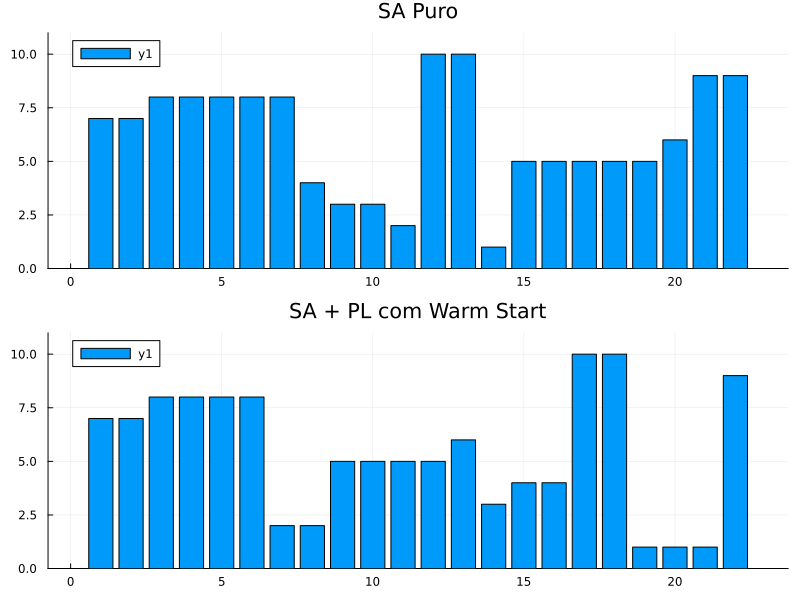

In [9]:
println("Solução com Warm Start:")
println("Carga máxima: ", objective_value(model_warm))
println("Gap de otimalidade: ", relative_gap(model_warm))

# Visualização comparativa
sa_assignment = best_solution
hybrid_assignment = [findfirst(j -> value(x[i,j]) > 0.5, 1:m) for i in 1:n]

p1 = bar(sa_assignment, title="SA Puro", ylim=(0,m+1))
p2 = bar(hybrid_assignment, title="SA + PL com Warm Start", ylim=(0,m+1))
plot(p1, p2, layout=(2,1), size=(800,600))